# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from IPython.display import clear_output
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as sm
import datetime

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
clear_output(wait=False)

In [ ]:
#Disable Autoscrolling in iPython Notebook

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
#Load raw data
df_vehicles = pd.read_csv('data/vehicles.csv')

In [6]:
# Copy the original data
df_backup = df_vehicles.copy()

#### Function Definitions (local) which will be used in this project's code

In [7]:
def ReturnMissingValuePerct(df):
    """
    Function that takes a dataframe and returns a dataframe containing the percentage of missing values and the mode of each 
    feature missing one or more values.
    Args:
        df: DataFrame
    Returns: 
        Dataframe
    """
    percent_missing = round(df.isnull().sum() * 100 / len(df),2)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df = missing_value_df[missing_value_df['percent_missing'] > 0.00]
    missing_value_df.set_index('column_name')
    missing_value_df.drop(columns=['column_name'],axis=1,inplace=True)

    #most recurring values from each feature that are missing values.
    cols = missing_value_df.index
    most_recurring_vals = []
    for c in cols:
        most_recurring_vals.append(df_vehicles[c].value_counts().index[0])
    missing_value_df['Most Recurring Value'] = most_recurring_vals

    return missing_value_df

In [8]:
def ReturnPercentileValue(df_input, cols,percentile):
    """
    Function to return the values based on the input percentile.
    Args:
        df: DataFrame - Input Dataframe
        cols - Columns to use on the dataframe
        percentile - percentile to calculate
    Returns: 
        Dataframe
    """
    df = pd.DataFrame(columns= cols)
    df['Percentile'] = percentile
    
    for c in cols:
        vals = []
        for perct in percentile:
            vals.append(int(np.nanpercentile(df_input[c], perct)))
        df[c] = vals
        
        
    df.set_index('Percentile', inplace=True)
    return df.sort_index()

In [9]:
def return_metrics(y_test, y_pred):
    """
    Function to return various metrics resulting from a regression
    Args:
        y_test: Actual target variable values from test (validation) set
        y_pred: Predicted values from test (validation set)
    Returns:
        list
    """
    r=[]
    r.append('%.4f' % r2_score(y_test,y_pred))
    r.append('%.4f' % (r2_score(y_test,y_pred)*100))
    r.append('%.2f' % mean_squared_error(y_test, y_pred))
    r.append('%.2f' % mean_absolute_error(y_test, y_pred))
    r.append('%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
    return (r)

In [10]:
#Rreturn index of a featured whose value count falls within the given percentage
def ReturnIndexOfThreshold(df, feature, threshPerct):
    df_values = df[feature].value_counts().reset_index().rename(columns={"index": "value"})
    df_values.rename(columns={df_values.columns[1]: 'count'}, inplace=True)
    count = df_values['count'].sum()
    i=0
    for index, row in df_values.iterrows():
        i+=row['count']
        if(round((i / count) * 100,2) >= threshPerct):
            return df_values, index
    return None

In [11]:
#permutation importance of models
def ReturnPermutationImportance(model, X_test, y_test, n_repeats, modelname=''):
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=n_repeats, random_state=22,)
    sorted_idx = perm_importance.importances_mean.argsort()[-20:]
    fig = plt.figure(figsize=(12, 10))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Permutation Importance of ' + modelname)
    return fig

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [12]:
# Explore data samples from dataframe
df_vehicles.head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
5,7222379453,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
6,7221952215,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
7,7220195662,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
8,7209064557,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or
9,7219485069,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa


In [13]:
# Data Description
df_vehicles.describe(include='all')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
count,4.268800e+05,426880,4.268800e+05,425675.000000,409234,421603,252776,249202,423867,4.224800e+05,418638,424324,265838,296313,120519,334022,296677,426880
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614
mean,7.311487e+09,NaN,7.519903e+04,2011.235191,NaN,NaN,NaN,NaN,NaN,9.804333e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.473170e+06,NaN,1.218228e+07,9.452120,NaN,NaN,NaN,NaN,NaN,2.138815e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.207408e+09,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.308143e+09,NaN,5.900000e+03,2008.000000,NaN,NaN,NaN,NaN,NaN,3.770400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.312621e+09,NaN,1.395000e+04,2013.000000,NaN,NaN,NaN,NaN,NaN,8.554800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.315254e+09,NaN,2.648575e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,1.335425e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### High level data tasks:
1.Pull the dataset into a data frame for analysis

2.Look at the data description to understand missing values and basic statistics of each feature

3.Transform the numeric features by standardizing them as needed

4.Transform the numeric features into numeric data

5.Encode the categorical features

6.Reduce the cardinality of features having a large number of unique values

7.Perform feature selection and regression analysis on the transformed data with price as the target variable

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1) <b>Data Collection </b> - Data has been acquired from Kaggle (<b>Used Cars Dataset</b>). The original dataset contained information on 3 million used cars out of 
which, we have pulled <b> only 426K records </b>.
2) <b>Data Description </b> - There are <b>426,880 rows </b> and <b>18 columns</b> in this dataset. The format of this raw data is a <b> .csv</b> file.
The target variable of the dataset is the column <b>"price"</b>.
3) <b>Data Quality </b>- There are several columns missing data as observed. If more than 80 % of values are missing, the entire column needs to be dropped.

In [22]:
#Data Quality Check
missing_values = ReturnMissingValuePerct(df_vehicles)
print('\nMissing Values:', missing_values)


Missing Values:               percent_missing Most Recurring Value
year                     0.28               2017.0
manufacturer             4.13                 ford
model                    1.24                f-150
condition               40.79                 good
cylinders               41.62          6 cylinders
fuel                     0.71                  gas
odometer                 1.03             100000.0
title_status             1.93                clean
transmission             0.60            automatic
VIN                     37.73    1FMJU1JT1HEA52352
drive                   30.59                  4wd
size                    71.77            full-size
type                    21.75                sedan
paint_color             30.50                white


##### None of the features are missing more than 80% of data. So we can keep all of the features for now

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1.<b>Data Cleanup </b>:

a)Column "size" is missing a significant percentage of values. Since the value for this column can be inferred from column "type", we can drop 
the column size.

b)Also, columns <b>"VIN", "Id", and "region" </b> (can we infer region from feature <b>"state"</b>) don't provide much value for prediction.
Therefore these columns can be dropped as well. 

c)Finally, drop records where the value of the target feature <b>"price"</b> is <b>0</b> as it doesn't provide any value for prediction.

In [23]:
#drop irrelavent columns
df_vehicles.drop(columns= ['size','VIN','id','region'], axis=1, inplace=True)

In [24]:
# drop records where price == 0
df_vehicles = df_vehicles[df_vehicles.price != 0]

2.<b>Remove Outliers</b>:

In [25]:
# Try these percentiles and check the price
outlier_percentiles = [1,2,3,4,5,6,7,8,9,10,99,99.5,99.6,99.7,99.8,99.9, 100]

In [26]:
# Check outliers of feature "price"
columns_outlier_check = ['price']

In [27]:
df_price_outliers = ReturnPercentileValue(df_vehicles,columns_outlier_check,outlier_percentiles)

In [28]:
df_price_outliers

,price
Percentile,
1.0,150
2.0,396
3.0,708
4.0,1300
5.0,1988
6.0,2495
7.0,2800
8.0,3000
9.0,3495


Based on the above analysis of column <b>"price"</b> for outliers by comparing the samples against Google to understand the actual real car price, it will be more 
appropriate to take the percentile from <b>5 up to 99.7 to remove outliers and invalid car prices </b>.

In [29]:
df_vehicles = df_vehicles.query('price >= price.quantile(.05) and price <= price.quantile(0.997)')

In [30]:
# check outliers of feature "odometer"
outlier_percentiles = [1,1.1,2,3,4,5,6.8,7,8,9,10,11,12,99,99.5,99.6,99.7,99.8,99.9, 100]
columns_outlier_check = ['odometer']
df_odometer = ReturnPercentileValue(df_vehicles,columns_outlier_check,outlier_percentiles)

In [31]:
df_odometer

,odometer
Percentile,
1.0,72
1.1,100
2.0,1111
3.0,3079
4.0,5277
5.0,7359
6.8,10439
7.0,10735
8.0,12345


Considering any used car <b>mileage above 10K miles as minimum</b> and <b>below 500 K as maximum</b>, it will be more appropriate to take the <b>percentile from 6.68 
and 99.7 </b>.

In [32]:
df_vehicles = df_vehicles.query('odometer >= odometer.quantile(0.068) and odometer <= odometer.quantile(0.997)')

3.<b>Handle missing values</b>:

In [33]:
df_missing_vals = ReturnMissingValuePerct(df_vehicles)
df_missing_vals

,percent_missing,Most Recurring Value
year,0.22,2017.0
manufacturer,3.51,ford
model,0.98,f-150
condition,38.41,good
cylinders,39.67,6 cylinders
fuel,0.61,gas
title_status,1.67,clean
transmission,0.40,automatic
drive,29.60,4wd
type,21.04,sedan


Features - <b>fuel, transmission, title_status, paint_color, and condition </b>- Replace the missing values with mode.

In [34]:
feature_replace = ['fuel','transmission','title_status', 'paint_color','condition']

In [35]:
for rec_val in feature_replace:
    df_vehicles[rec_val].fillna(df_missing_vals['Most Recurring Value'][rec_val], inplace=True)

Features - <b>year, manufacturer, and model</b> - These features are missing only a few values. Delete records having <b>"Null"</b> values for one or more of these features.

In [36]:
feature_rows_delete_ifnull = ['year','manufacturer','model']

In [37]:
df_vehicles = df_vehicles.dropna(axis=0,subset=feature_rows_delete_ifnull)

Features- <b>cylinders and type </b> has a value called "other". We can use this value to replace the missing values for these features

In [38]:
df_vehicles['cylinders'].fillna('other',inplace=True)
df_vehicles['type'].fillna('other',inplace=True)

Fill <b>Null</b> values for feature <b>drive</b> with value <b>fwd</b> as its the most common drivetrain.

In [39]:
df_vehicles['drive'].fillna('fwd',inplace=True)

In [40]:
#check for null values after filling all missing values. It should be empty
print(ReturnMissingValuePerct(df_vehicles))

Empty DataFrame
Columns: [percent_missing, Most Recurring Value]
Index: []


4.<b>Transform values </b>:

Transform the feature <b>"Year"</b> to <b>age</b>

In [41]:
today = datetime.date.today()
year = today.year
df_vehicles['vehicle_age'] = year - df_vehicles['year']
df_vehicles.drop(columns= 'year', inplace=True)

Use only the <b>main model</b> of the vehicle by <b>ignoring the trims</b>. Also, ignore the word <b>"cylinders"</b> in the feature cylinder

In [42]:
df_vehicles['model'] = df_vehicles['model'].apply(lambda x:x.split(' ')[0])

In [43]:
df_vehicles['cylinders'] = df_vehicles['cylinders'].apply(lambda x:x.split(' ')[0])

Since the <b>automatic transmission</b> is the most popular in the US, we can change the transmission having value as <b>"other" to "automatic"</b>

In [44]:
df_vehicles['transmission'].replace('other','automatic', inplace=True)

Reduce the cardinality of Features - <b> Model, Manufacturer </b>

In [45]:
df_manufacturer, manufacturer_index = ReturnIndexOfThreshold(df_vehicles,'manufacturer',threshPerct=90)

In [46]:
df_model, model_index = ReturnIndexOfThreshold(df_vehicles,'model',threshPerct=50)

In [47]:
#Reduce the cardinality of feature model
df_vehicles['model'] = df_vehicles['model'].apply(lambda m: m if str(m) in list(df_model['value'][:model_index]) else 'others')

In [48]:
#Reduce the cardinality of feature manufacturer
df_vehicles['manufacturer'] = df_vehicles['manufacturer'].apply(lambda m: m if str(m) in list(df_manufacturer['value'][:manufacturer_index]) else 'others')

Transform column <b>title_status</b> by moving status <b>"lien"</b> to <b>"clean"</b> and all other statuses to <b>"other"</b>

In [50]:
df_vehicles['title_status'] = df_vehicles['title_status'].map({'clean':'clean','rebuilt':'other','salvage':'other','lien':'clean','missing':'other', \
                                  'parts only':'other'})

There are used cars that are <b>over 100 years old</b> in the dataset. To make the year relevant, we can eliminate used cars <b>beyond 30 years old</b> from our 
dataset.

In [51]:
df_vehicles = df_vehicles.query('vehicle_age <= 30')

In [52]:
#checkif the data is cleaned by examining head
df_vehicles.head()

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,vehicle_age
27,33590,gmc,sierra,good,8,gas,57923.0,clean,automatic,fwd,pickup,white,al,10.0
28,22590,chevrolet,silverado,good,8,gas,71229.0,clean,automatic,fwd,pickup,blue,al,14.0
29,39590,chevrolet,silverado,good,8,gas,19160.0,clean,automatic,fwd,pickup,red,al,4.0
30,30990,toyota,tundra,good,8,gas,41124.0,clean,automatic,fwd,pickup,red,al,7.0
31,15000,ford,f-150,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,al,11.0


Transform the <b>categorical variables to numeric </b> to be used for further analysis in Feature Engineering using Column Transformer

In [53]:
ordinal_orders=[['salvage', 'fair', 'unknown', 'good', 'excellent', 'like new', 'new']]
num_cols = ['odometer']
ordinal_features = ['condition']
catcols = df_vehicles.select_dtypes(include=['object']).columns.tolist()
catcols.remove('condition')

In [54]:
column_transformer = ColumnTransformer(transformers= [
    ('ordinal_encoder', OrdinalEncoder(categories = ordinal_orders),ordinal_features),
    ('one_hot_encoder', OneHotEncoder(drop='if_binary', sparse = False), catcols),
    ('standard_scaler', StandardScaler(),num_cols),
],   remainder='passthrough')

In [55]:
X = column_transformer.fit_transform(df_vehicles.drop('price', axis=1))
y = df_vehicles[['price']]

In [56]:
lstNewFeatures = list(column_transformer.get_feature_names_out())
lstNewFeatures = [sub.split('__')[1] for sub in lstNewFeatures]

In [57]:
X1 = pd.DataFrame(data=X, columns=lstNewFeatures)

In [58]:
X1 = X1.reset_index(drop=True)
y = y.reset_index(drop=True)

In [59]:
# Perform OLS and retrieve p-values. Remove features with p-values > 0.05 to see if there is any improvement in R2 and 
#Adjusted R2 scores.
X = sm.add_constant(X1)
results_linreg = sm.OLS(y,X).fit()
print(results_linreg.rsquared)
print(results_linreg.rsquared_adj)

0.7541529029255366
0.7540302755986359


In [60]:
# Coefficients and p_values. Features where p-value is > 0.05
summary_df = pd.DataFrame(data=X1.columns.tolist(), columns=['Features'])
summary_df.set_index('Features', inplace=True)
summary_df['p-values'] = np.array(round(results_linreg.pvalues.iloc[1:],3).tolist(), dtype=float)
summary_df['coeff'] = np.array(round(results_linreg.params.iloc[1:],3).tolist(), dtype = float)
features_to_remove = list(summary_df[summary_df['p-values'] > 0.05].sort_values(by='p-values', ascending=True).index)

In [61]:
X.drop(columns=features_to_remove, inplace=True)

In [62]:
results_linreg = sm.OLS(y,X).fit()
print(results_linreg.rsquared)
print(results_linreg.rsquared_adj)

0.7541439501726083
0.7540289864511077


There is not much of an improvement in R2 scores. So we will <b>retain all the features</b> & no features needs to be dropped.

##### Test / Train Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=42)
X_train.shape

(224653, 168)

In [64]:
y_train.shape

(224653, 1)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [65]:
metrics_df = pd.DataFrame(index=['R2 Score', 'Accuracy(%)', 'Mean Squared Error', 'Mean Absolute Error', 'Root MSE'])

#### Linear Regression

In [66]:
linreg = LinearRegression()
linreg_model = linreg.fit(X_train, y_train)
y_pred = linreg_model.predict(X_test)
linreg_score = return_metrics(y_test, y_pred)
metrics_df['Linear Regression'] = linreg_score

#### Ridge Regression (L2 Regularization)


In [67]:
ridge_estimator = Ridge()
alphas_to_try = {'alpha':(np.linspace(-5,30,10))}
ridge_model_finder = GridSearchCV(estimator=ridge_estimator,
                            param_grid=alphas_to_try
                            )
ridge_model_finder.fit(X_train,y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([-5.        , -1.11111111,  2.77777778,  6.66666667, 10.55555556,
       14.44444444, 18.33333333, 22.22222222, 26.11111111, 30.        ])})

In [68]:
ridge_model = ridge_model_finder.best_estimator_
ridge_model

Ridge(alpha=6.666666666666666)

In [69]:
y_pred = ridge_model.predict(X_test)

In [70]:
ridgereg_score = return_metrics(y_test, y_pred)
metrics_df['Ridge Regression'] = ridgereg_score

##### Lasso Regression ( L1 Regularization)


In [71]:
lasso_estimator = Lasso()
lasso_model_finder = GridSearchCV(estimator=lasso_estimator,
                            param_grid=alphas_to_try
                            )
lasso_model_finder.fit(X_train,y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([-5.        , -1.11111111,  2.77777778,  6.66666667, 10.55555556,
       14.44444444, 18.33333333, 22.22222222, 26.11111111, 30.        ])})

In [72]:
lasso_model = lasso_model_finder.best_estimator_
y_pred = lasso_model.predict(X_test)
lassoreg_score = return_metrics(y_test, y_pred)
metrics_df['Lasso Regression'] = lassoreg_score


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [73]:
#print the metrics dataframe
metrics_df

,Linear Regression,Ridge Regression,Lasso Regression
R2 Score,0.7540,0.7541,0.7534
Accuracy(%),75.4039,75.4051,75.3354
Mean Squared Error,44127931.57,44125779.55,44250770.02
Mean Absolute Error,4699.01,4698.68,4701.18
Root MSE,6642.89,6642.72,6652.13


##### From the above metrics, all three models have the same level of testing accuracy.

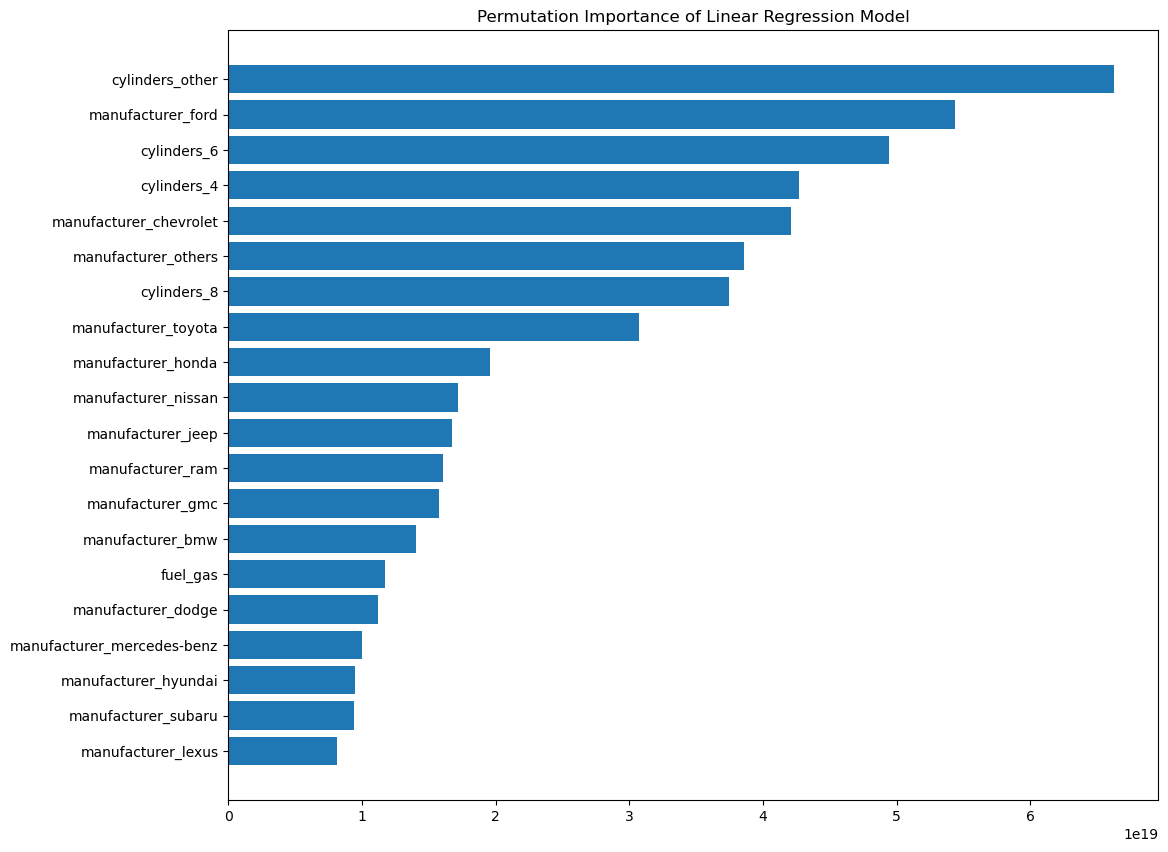

In [74]:
#Permutation importance of Linear Regression Model
ReturnPermutationImportance(linreg_model,X_test, y_test, 20, "Linear Regression Model").show()

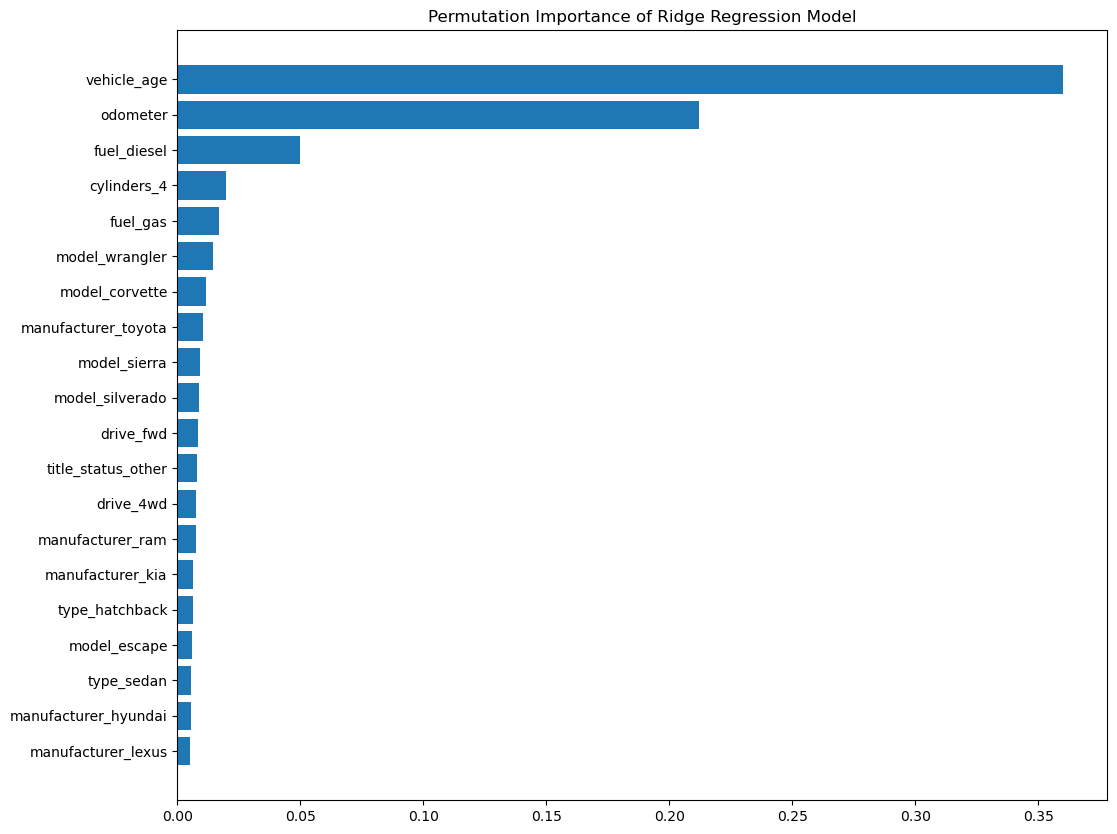

In [75]:
#Permutation importance of Ridge Regression Model
ReturnPermutationImportance(ridge_model,X_test, y_test, 20, "Ridge Regression Model").show()

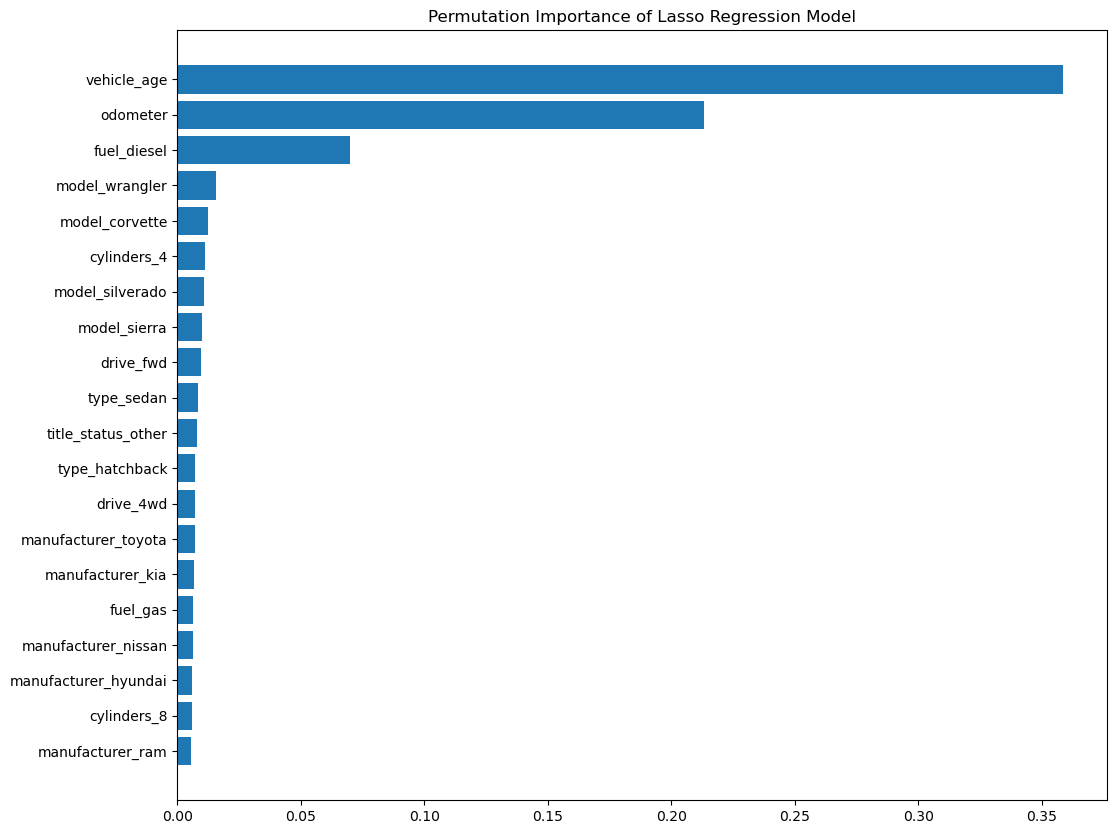

In [76]:
#Permutation importance of Lasso Regression Model
ReturnPermutationImportance(lasso_model,X_test, y_test, 20, "Lasso Regression Model").show()

Based on the permutation importance from all three models, the features selected by <b>Ridge</b>and <b>Lasso</b> are more accurate as Vehicle age and odometer (mileage) plays a pivotal role in assessing an used car price.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

 The used car delarship had <b>426000 cars</b> for analysis. The dataset had many <b>insignigicant properties, inappropriate and missing values</b>. The recommendation from this analysis to the dealership are as follows:

1)<b>Vehicle Mileage</b> - Recommend the dealer to ensure the odometer reading on the cars in inventory are correct as we have encountered vehicles over 500 thousand miles in them. These were eliminated as part of our analysis.

2)<b>Vehicle Age</b> - Recommend the dealer to ensure the vehicle year of manufacture is correct as we have encountered vehicles over 100 years old in them. According to our study, used cars that are over 30 years are normally sold at a flat rate and they become a vintage care beyond 40 years based on the make and model. Therefore, we considered only cars that are below 30 years old for the purpose of our analysis.

3)<b>Price</b> - Recommend the dealer to ensure the price is set appropriately. There are cars with price tags in millions. Recommend dealer to be cautious when applying a price tag to the used car in the inventory.



Based on our analysis, <b>vehicle's age</b> and <b>mileage</b> plays an important role in determining or improving the price of the vehicle.The dealer should set the price depending upon these two features.